# SMART LIVE CAMERA NOTEBOOK

## Necessary modules

In [1]:
# Import Modules
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sys
import tarfile
import seaborn
import random
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import display, Image
from scipy import ndimage
from scipy.misc import imresize
from scipy.io import loadmat
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

## Generic functions

### Data Preprocessing Functions

In [2]:
last_percent_reported = None
num_classes = 10

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(URL + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

def maybe_extract(filename, force=False):
  """Extract a file (tar). If force=True, override the current files and folders"""
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders

### Eval Functions

In [152]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

def pred_acc(predictions, labels):
  return (100.0 * np.sum(predictions == labels) / predictions.shape[1] / predictions.shape[0])

def check_predictions(original, labels, predictions):
  print('Accuracy: %.1f%%' % pred_acc(predictions, labels))
  for i, sample in enumerate(original):
    sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
    plt.imshow(sample)
    plt.show()
    l_ele = labels[i]
    p_ele = predictions[i]
    print('Label %s - Prediction %s' % (l_ele[l_ele != 10], p_ele[p_ele != 10]))
    if (i == 10):
      break

## 3. STEP THREE: MULTI DIGIT SVHN DATA

### Downloading data

In [141]:
mnist = input_data.read_data_sets('MNIST_data/', one_hot=False)
train_dataset = mnist.train.images
train_labels = mnist.train.labels
test_dataset = mnist.test.images
test_labels = mnist.test.labels
valid_dataset = mnist.validation.images
valid_labels = mnist.validation.labels
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Training set (55000, 784) (55000,)
Validation set (5000, 784) (5000,)
Test set (10000, 784) (10000,)


### Reformat

In [142]:
IMAGE_SIZE = 28
NUM_CHANNELS = 1
NUM_LABELS = 10

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)).astype(np.float32)
  labels = labels.astype(np.int32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (55000, 28, 28, 1) (55000,)
Validation set (5000, 28, 28, 1) (5000,)
Test set (10000, 28, 28, 1) (10000,)


#### CHECK 

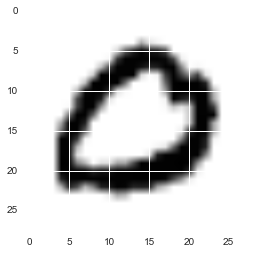

0


In [143]:
rd = 19
sample = train_dataset[rd,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

print(train_labels[rd])

### CREATING THE SEQUENCE

In [146]:
IMAGE_SIZE = 28
NUM_CHANNELS = 1
NUM_LABELS = 11 # 0-9 and no digit
N = 5 # max number of digits on the sequence

np.random.seed(42)
  
def create_sequences(images, labels):
  
  #if type(train_labels[0]).__module__ == np.__name__:
  #  print('Sequence already created')
  #  return images, labels
  
  length = images.shape[0]
  index = 0
  seq_images = np.ndarray([length,IMAGE_SIZE,IMAGE_SIZE,NUM_CHANNELS], dtype='float32')
  seq_labels = np.ones([length, N], dtype=int) * 10 # init to 10 cause it would be no digit
  
  while index < length:
    # Random
    L = random.randint(1, N)
    offset = random.randint(0, length-N)
    # Image
    selected = images[offset:offset+L,:,:,:] 
    sequence = np.hstack(selected) #28x28*Lx1
    sequence = sequence.reshape(sequence.shape[0], sequence.shape[1],).astype(np.float32) #28x28xL
    sequence_resized = imresize(sequence, (IMAGE_SIZE,IMAGE_SIZE)) #28x28
    sequence_resized = sequence_resized.reshape((IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)).astype(np.float32) #28x28x1
    seq_images[index] = sequence_resized
    # Label
    for local_index in range(L):
      seq_labels[index, local_index] = labels[offset+local_index]
      
    index += 1
      
  return seq_images, seq_labels

In [83]:
## TODO INCLUDE L

In [147]:
train_dataset, train_labels = create_sequences(train_dataset, train_labels)
test_dataset, test_labels = create_sequences(test_dataset, test_labels)
valid_dataset, valid_labels = create_sequences(valid_dataset, valid_labels)


print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)  

Training set (55000, 28, 28, 1) (55000, 5)
Validation set (5000, 28, 28, 1) (5000, 5)
Test set (10000, 28, 28, 1) (10000, 5)


#### CHECK

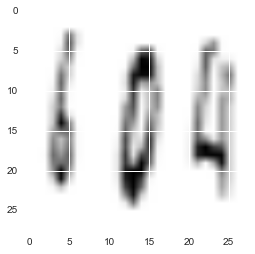

[ 6  0  4 10 10]


In [148]:
sample = train_dataset[123,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

print(train_labels[123])

#### Randomize

In [149]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)  

Training set (55000, 28, 28, 1) (55000, 5)
Validation set (5000, 28, 28, 1) (5000, 5)
Test set (10000, 28, 28, 1) (10000, 5)


#### CHECK

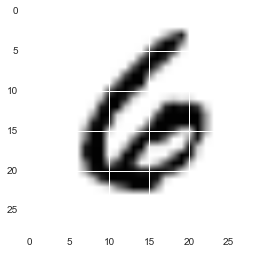

[ 6 10 10 10 10]


In [150]:
sample = train_dataset[123,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

print(train_labels[123])

### NOT PICKLE NEEDED WITH MNIST DATA!!!

### ConvNet 3L - Fully Connected - No Reg - AdaOptimizer 

In [90]:
IMAGE_SIZE = 28
NUM_CHANNELS = 1
NUM_LABELS = 11
N = 5

BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH_1 = 16
DEPTH_2 = 32
DEPTH_3 = 64
HIDDEN_NODES = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
  tf_train_labels = tf.placeholder(tf.int64, shape=(BATCH_SIZE, N))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # 5x5 Filter, depth 16 
  conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH_1], stddev=0.1))
  conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))
  
  # 5x5 Filter, depth 32
  conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1))
  conv2_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_2]))
  
  # 5x5 Filter, depth 64
  conv3_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], stddev=0.1))
  conv3_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_3]))

  # Linear 
  N1_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS],stddev=0.1))
  N1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N2_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N3_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N3_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N4_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N4_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N5_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N5_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  #NL_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  #NL_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  # Model.
  def model(data):
    
    kernel1 = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.relu(tf.nn.bias_add(kernel1, conv1_biases))
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm1 = tf.nn.local_response_normalization(pool1)
    
    kernel2 = tf.nn.conv2d(norm1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(tf.nn.bias_add(kernel2, conv2_biases))
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm2 = tf.nn.local_response_normalization(pool2)

    kernel3 = tf.nn.conv2d(norm2, conv3_weights, [1, 1, 1, 1], padding='VALID')
    conv3 = tf.nn.relu(tf.nn.bias_add(kernel3, conv3_biases))
    norm3 = tf.nn.local_response_normalization(conv3)
    pool = tf.nn.max_pool(norm3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #pool = norm3
    
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
    
    # Linear Extraction for each component
    feature_1 = tf.nn.bias_add(tf.matmul(reshape, N1_weights), N1_biases)
    feature_2 = tf.nn.bias_add(tf.matmul(reshape, N2_weights), N2_biases)
    feature_3 = tf.nn.bias_add(tf.matmul(reshape, N3_weights), N3_biases)
    feature_4 = tf.nn.bias_add(tf.matmul(reshape, N4_weights), N4_biases)
    feature_5 = tf.nn.bias_add(tf.matmul(reshape, N5_weights), N5_biases)
    
    return feature_1, feature_2, feature_3, feature_4, feature_5  
  
  logits1, logits2, logits3, logits4, logits5 = model(tf_train_dataset)
  
  l1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,0]))
  l2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,1]))
  l3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,2]))
  l4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,3]))
  l5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits5, tf_train_labels[:,4]))
  
  loss = l1+l2+l3+l4+l5
    
  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset)[0]),\
                      tf.nn.softmax(model(tf_train_dataset)[1]),\
                      tf.nn.softmax(model(tf_train_dataset)[2]),\
                      tf.nn.softmax(model(tf_train_dataset)[3]),\
                      tf.nn.softmax(model(tf_train_dataset)[4])])
  valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset)[0]),\
                      tf.nn.softmax(model(tf_valid_dataset)[1]),\
                      tf.nn.softmax(model(tf_valid_dataset)[2]),\
                      tf.nn.softmax(model(tf_valid_dataset)[3]),\
                      tf.nn.softmax(model(tf_valid_dataset)[4])])
  test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset)[0]),\
                     tf.nn.softmax(model(tf_test_dataset)[1]),\
                     tf.nn.softmax(model(tf_test_dataset)[2]),\
                     tf.nn.softmax(model(tf_test_dataset)[3]),\
                     tf.nn.softmax(model(tf_test_dataset)[4])])
  
  saver = tf.train.Saver()

  
NUM_STEPS = 10001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  sp = saver.restore(session, "tmp/MNIST-CNN-multi-1.ckpt")
  print('Model Restored')
  print('Initialized')
  for step in range(NUM_STEPS):    
    offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
    batch_data = train_dataset[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE),:]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  sp = saver.save(session, "tmp/MNIST-CNN-multi-1.ckpt")
  print('Model Saved')
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Model Restored
Initialized
Minibatch loss at step 0: 2.045012
Minibatch accuracy: 89.1%
Validation accuracy: 90.2%
Minibatch loss at step 500: 1.649527
Minibatch accuracy: 93.4%
Validation accuracy: 90.3%
Minibatch loss at step 1000: 2.251368
Minibatch accuracy: 90.3%
Validation accuracy: 90.6%
Minibatch loss at step 1500: 2.276315
Minibatch accuracy: 90.3%
Validation accuracy: 90.8%
Minibatch loss at step 2000: 2.316708
Minibatch accuracy: 86.6%
Validation accuracy: 91.0%
Minibatch loss at step 2500: 1.522700
Minibatch accuracy: 93.4%
Validation accuracy: 91.3%
Minibatch loss at step 3000: 1.910658
Minibatch accuracy: 91.9%
Validation accuracy: 91.4%
Minibatch loss at step 3500: 1.610966
Minibatch accuracy: 93.4%
Validation accuracy: 91.7%
Minibatch loss at step 4000: 1.950307
Minibatch accuracy: 90.6%
Validation accuracy: 91.8%
Minibatch loss at step 4500: 1.312314
Minibatch accuracy: 95.9%
Validation accuracy: 91.9%
Minibatch loss at step 5000: 1.961287
Minibatch accuracy: 91.2%
Val

### Let's make some preds 

In [94]:
test_samples = test_dataset[0:64]
print(test_samples.shape)

(64, 28, 28, 1)


Model Restored
Initialized
Accuracy: 94.4%


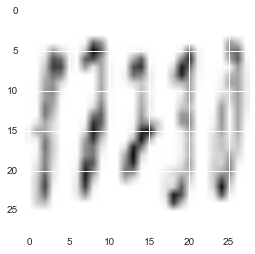

Label [8 2 2 3 0] - Prediction [8 2 2 3 0]


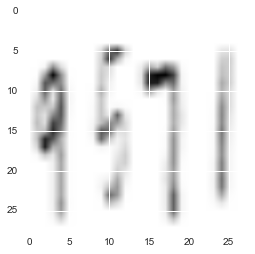

Label [9 5 7 1] - Prediction [9 5 7 1]


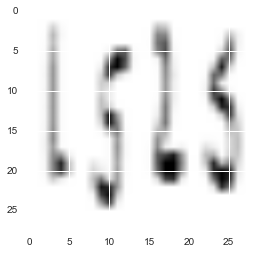

Label [1 5 2 5] - Prediction [1 5 2 5]


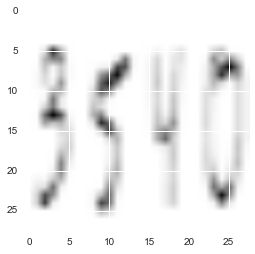

Label [3 5 4 0] - Prediction [3 5 4 0]


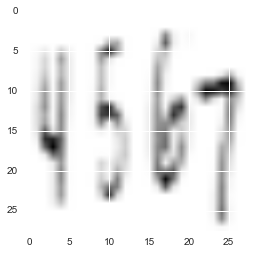

Label [4 5 6 7] - Prediction [4 5 6 7]


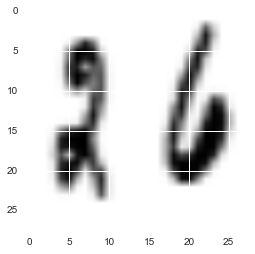

Label [2 6] - Prediction [2 6]


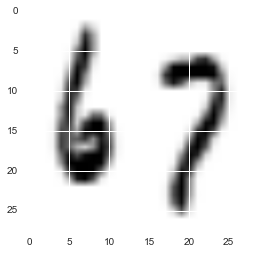

Label [6 7] - Prediction [6 7]


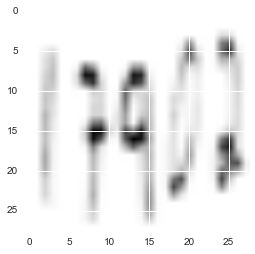

Label [1 7 9 0 2] - Prediction [1 7 9 0 2]


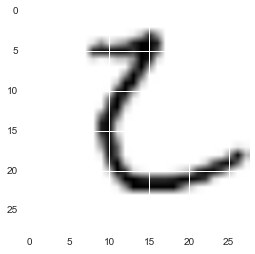

Label [2] - Prediction [2]


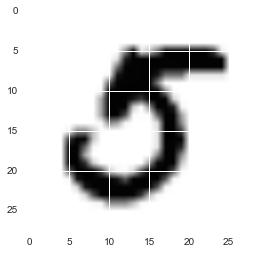

Label [5] - Prediction [5]


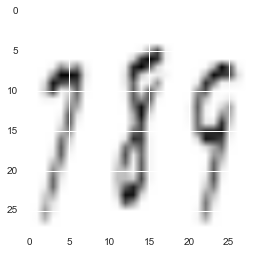

Label [7 8 9] - Prediction [7 8 9]


In [158]:
SAMPLES = 64

IMAGE_SIZE = 28
NUM_CHANNELS = 1
NUM_LABELS = 11
N = 5

BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH_1 = 16
DEPTH_2 = 32
DEPTH_3 = 64
HIDDEN_NODES = 64

graph = tf.Graph()

with graph.as_default():
  
  # Input data.
  tf_test_dataset = tf.placeholder(tf.float32, shape=(SAMPLES, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
  
  # Variables.
  # 5x5 Filter, depth 16 
  conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH_1], stddev=0.1))
  conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))
  
  # 5x5 Filter, depth 32
  conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1))
  conv2_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_2]))
  
  # 5x5 Filter, depth 64
  conv3_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], stddev=0.1))
  conv3_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_3]))

  # Linear 
  N1_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS],stddev=0.1))
  N1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N2_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N3_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N3_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N4_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N4_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  N5_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  N5_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  #NL_weights = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS], stddev=0.1))
  #NL_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  # Model.
  def model(data):
    
    kernel1 = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='VALID')
    conv1 = tf.nn.relu(tf.nn.bias_add(kernel1, conv1_biases))
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm1 = tf.nn.local_response_normalization(pool1)
    
    kernel2 = tf.nn.conv2d(norm1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(tf.nn.bias_add(kernel2, conv2_biases))
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm2 = tf.nn.local_response_normalization(pool2)

    kernel3 = tf.nn.conv2d(norm2, conv3_weights, [1, 1, 1, 1], padding='VALID')
    conv3 = tf.nn.relu(tf.nn.bias_add(kernel3, conv3_biases))
    norm3 = tf.nn.local_response_normalization(conv3)
    pool = tf.nn.max_pool(norm3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #pool = norm3
    
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
    
    # Linear Extraction for each component
    feature_1 = tf.nn.bias_add(tf.matmul(reshape, N1_weights), N1_biases)
    feature_2 = tf.nn.bias_add(tf.matmul(reshape, N2_weights), N2_biases)
    feature_3 = tf.nn.bias_add(tf.matmul(reshape, N3_weights), N3_biases)
    feature_4 = tf.nn.bias_add(tf.matmul(reshape, N4_weights), N4_biases)
    feature_5 = tf.nn.bias_add(tf.matmul(reshape, N5_weights), N5_biases)
    
    return feature_1, feature_2, feature_3, feature_4, feature_5  
  
  logits1, logits2, logits3, logits4, logits5 = model(tf_test_dataset)
  
  predictions = tf.pack([tf.nn.softmax(model(tf_test_dataset)[0]),\
                     tf.nn.softmax(model(tf_test_dataset)[1]),\
                     tf.nn.softmax(model(tf_test_dataset)[2]),\
                     tf.nn.softmax(model(tf_test_dataset)[3]),\
                     tf.nn.softmax(model(tf_test_dataset)[4])])
  
  test_predictions = tf.transpose(tf.argmax(predictions, 2))
  
  saver = tf.train.Saver()    
  
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  sp = saver.restore(session, "tmp/MNIST-CNN-multi-1.ckpt")
  print('Model Restored')
  print('Initialized')
  offset = random.randint(0, test_dataset.shape[0]-SAMPLES)
  test_samples = test_dataset[offset:offset+SAMPLES]
  test_samples_labels = test_labels[offset:offset+SAMPLES]
  test_predictions = session.run(test_predictions, feed_dict={tf_test_dataset : test_samples})
  check_predictions(test_samples, test_samples_labels, test_predictions)
  